In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
df = pd.read_csv("./data.csv",engine='python',parse_dates=['InvoiceDate'])
data = df.copy()
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [47]:
#checking for null values
#There seem to be null descriptions which should be fine
#null customer ids which shouldn't pose a problem as well
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


InvoiceNo: Invoice Number

StockCode: Product Code

Description: Product name

Quantity: Quantities of each product per transaction

InvoiceDate: Invoice date and time

UnitPrice: Product price per unit in STERLING

CustomerID: Customer number

Country: Country name

In [48]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Analyzing Negative Quantities

C:\Users\ventu\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ventu\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


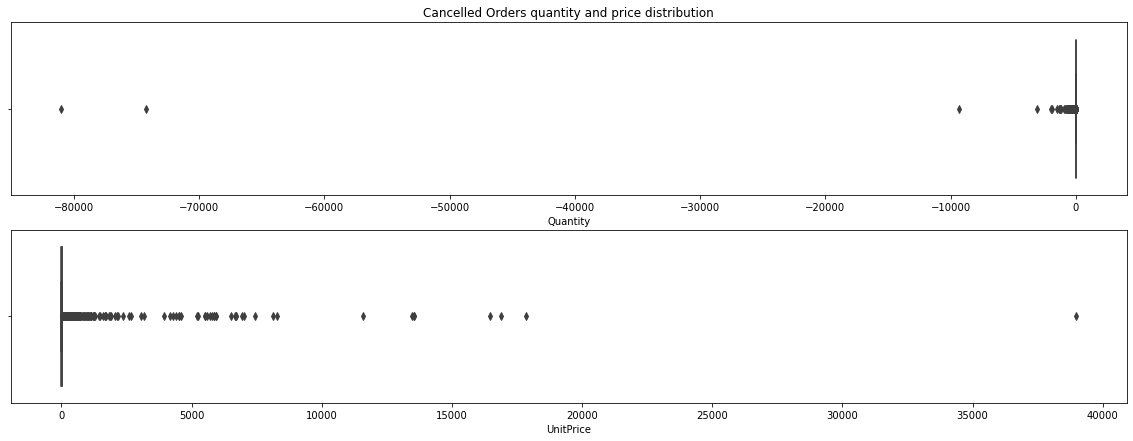

In [49]:
fig, ax = plt.subplots(nrows=2, figsize=(20,7))
sns.boxplot(data[(data['InvoiceNo'].str[0]=='c')|(data['InvoiceNo'].str[0]=='C')]
           ['Quantity'], ax=ax[0])
sns.boxplot(data[(data['InvoiceNo'].str[0]=='c')|(data['InvoiceNo'].str[0]=='C')]
           ['UnitPrice'],ax=ax[1])
ax[0].title.set_text('Cancelled Orders quantity and price distribution')

# Negative Quantities withough 'C' in InvoiceNo, denoting cancellation

In [50]:
neg_qty = data[data['Quantity']<0]
neg_qty_without_C = neg_qty[neg_qty['InvoiceNo'].str[0] != 'C']

print("Negative Qty without 'C' in InvoiceNo \n Unit Prices: {} \t CustomerIDs: {}".format(neg_qty_without_C["UnitPrice"].unique(),neg_qty_without_C["CustomerID"].unique()))

Negative Qty without 'C' in InvoiceNo 
 Unit Prices: [0.] 	 CustomerIDs: [nan]


All negative quantities that don't have the prefix C in the label have a unit price of zero so they will not present any errors into our calculations.

#### Hypothesis: Rows with negative quantities mean the order was placed and then cancelled
To prove this there must be matching customer IDs, the quantity ordered must be less than or equal to quantity cancelled and the order date must be before the order cancelled date.
Note: It only has to be for a majority for this to be plausible since the initial months will only have cancellation data and not order data due to data cut conditions.

In [51]:
def check_hypothesis_cancelled_order(df):
    failed = 0
    passed = 0
    neg_qty = df[df['Quantity']<0]
    pos_qty = df[~df['Quantity']>0]
    
    #for every index in negatitive quantity data
    for ind in neg_qty.index:
        #if customer id exists in negative quantity data
        if(neg_qty['CustomerID'][ind]):
            #p is equal to index of any item that
            #customer id matches with customer id of negative quantities
            #positive quantity is less than the negative quantity
            #order date was before cancelled date
            p = pos_qty[
                (pos_qty['CustomerID'] == neg_qty['CustomerID'][ind])&
                (pos_qty['Quantity'] <= abs(neg_qty['Quantity'][ind]))&
                ((pos_qty['InvoiceDate'] - neg_qty['InvoiceDate'][ind]).dt.total_seconds()>=0)
            ]
            
            if(len(p)==0):
                failed+=1
            else:
                passed+=1
    if(failed>passed):
        print('Hypothesis Rejected!')
        print('Failed Counts:'+str(failed)+' Passed Counts:'+str(passed))
        print('Approximately '+str(int(failed/(failed + passed)*100)) + "% rows didnt satisfy the condition")
    else:
        print("Hypothesis Accepted")
        print('Failed Counts:'+str(failed)+' Passed Counts:'+str(passed))
        print('Approximately '+str(int(passed/(failed + passed)*100)) + "% rowssatisfy the condition")

In [52]:
check_hypothesis_cancelled_order(data)

Hypothesis Accepted
Failed Counts:2754 Passed Counts:7870
Approximately 74% rowssatisfy the condition


In [53]:
from difflib import SequenceMatcher

## Feature Generating

In [54]:
def get_product_name(x):
    max_upper_count = 0
    product_name = ''
    for i in x:
        #if it has same number of letters or null
        if(i==i):
            count = 0
            for letter in i:
                if(letter.isupper()):
                    count = count + 1
            if count > max_upper_count:
                max_upper_count = count
                product_name = i
    return product_name

In [55]:
grouped = data.groupby("StockCode")["Description"].unique()
lookup = grouped.apply(get_product_name)

In [56]:
data = data.join(other=lookup, on='StockCode', how='left', rsuffix='ProductionName')
data = data.rename(columns={'DescriptionProductionName': 'ProductName'})

In [57]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ProductName
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,WHITE MOROCCAN METAL LANTERN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,CREAM CUPID HEARTS COAT HANGER
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.


In [58]:
des = data['Description']
prod = data['ProductName']
dist = []
for d,p in zip(des, prod):
    try:
        dist.append(SequenceMatcher(None,d,p).ratio())
    except:
        dist.append(0)
        

In [59]:
dist

[1.0,
 0.8085106382978723,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.76,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.76,
 1.0,
 1.0,
 0.8085106382978723,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.35294117647058826,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8085106382978723,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.35294117647058826,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.76,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.5230769230769231,
 0.46875,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9285714285714286,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.6842105263157895,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 

In [60]:
data['dist'] = dist
data[(data['dist']<0.3)&(data['dist']!=0)][['StockCode','Description','ProductName','dist']]

,StockCode,Description,ProductName,dist
22296,46000S,Dotcom sales,POLYESTER FILLER PAD 40x40cm,0.150000
22297,46000M,Dotcom sales,POLYESTER FILLER PAD 45x45cm,0.150000
30555,22734,amazon sales,SET OF 6 RIBBONS VINTAGE CHRISTMAS,0.043478
39047,85135B,Found,BLUE DRAGONFLY HELICOPTER,0.066667
42564,22501,reverse 21/5/10 adjustment,PICNIC BASKET WICKER LARGE,0.076923
...,...,...,...,...
524369,23406,CHECK,HOME SWEET HOME KEY HOLDER,0.193548
524622,22927,Amazon,GREEN GIANT GARDEN THERMOMETER,0.055556
532724,22481,wet boxes,BLACK TEA TOWEL CLASSIC DESIGN,0.051282
535329,21693,mixed up,SMALL HAMMERED SILVER CANDLEPOT,0.050000


### Feature Generation: Total Price

In [61]:
data['TotalPrice'] = data['UnitPrice'] * data['Quantity']

In [62]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ProductName,dist,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,1.000000,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,WHITE MOROCCAN METAL LANTERN,0.808511,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,CREAM CUPID HEARTS COAT HANGER,1.000000,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,1.000000,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,1.000000,20.34


### Removing Cancelled Products

In [63]:
cancelled_data = data[data['InvoiceNo'].str[0] == 'C']
data = data[~(data['InvoiceNo'].str[0]=='C')]
cancelled_data = cancelled_data.reset_index(drop=True)

In [64]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ProductName,dist,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,1.000000,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,WHITE MOROCCAN METAL LANTERN,0.808511,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,CREAM CUPID HEARTS COAT HANGER,1.000000,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,1.000000,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,1.000000,20.34
